In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# GAN

copy from https://www.kaggle.com/amanooo/wgan-gp-keras/notebook?select=all-dogs.zip

In [ ]:
import numpy as np
import pandas as pd

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time
import random

import matplotlib.pyplot as plt
import cv2


from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image

In [3]:
import keras
import cv2
import numpy as np

(raw_x, _), (_, _) = keras.datasets.mnist.load_data()


X_train = raw_x.copy()
print(X_train.shape)

def resize(target):
    return cv2.resize(target, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)

resized = np.ones((60000,32,32))
for i in range(X_train.shape[0]):
    resized[i] = resize(X_train[i])

X_train = resized
X_train = (X_train / 127.5) - 1.0
X_train = np.expand_dims(X_train, -1)
print(X_train.shape)
print(X_train.min(), X_train.max())




(60000, 28, 28)
(60000, 32, 32, 1)
-1.0 1.0


In [ ]:
img_size = 32
channels = 1
img_shape = (img_size, img_size, channels)    # (32, 32, 1)

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 32
rec_interval = 10000

DIR = os.getcwd()
DIRout = "../output_images"

In [ ]:
def build_generator():
    input = Input(shape=z_shape)
    x = Dense(8*img_size*img_size, activation="relu")(input)
    x = Reshape((img_size//8, img_size//8, -1))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same",
               use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
#     x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh",
#                use_bias=False,)(x)
    x = Conv2D(channels, kernel_size=3, strides=1, padding="same", activation="tanh",
               use_bias=False,)(x)
    

    model = Model(input, x)
    print("generator")
    model.summary()
    return model

In [ ]:
def build_discriminator():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("discriminator")
    model.summary()
    return model

In [ ]:
def build_WGANgp(generator, discriminator):
    #### model
    # generator image(fake image)
    z = Input(shape=z_shape)
    f_img = generator(z)
    f_out = discriminator(f_img)
    # real image
    r_img = Input(shape=img_shape)
    r_out = discriminator(r_img)
    # average image
    epsilon = K.placeholder(shape=(None,1,1,1))
    a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
    a_out = discriminator(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed -1))
    penalty = penaltyLambda * grad_penalty
    # d loss
    d_loss = f_loss - r_loss + penalty
    
    #### discriminator update function
    d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(discriminator.trainable_weights,[],d_loss)
    d_train = K.function([r_img, z, epsilon],
                         [r_loss, f_loss, penalty, d_loss],
                         d_updates)
    
    #### generator update function
    g_loss = -1. * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(generator.trainable_weights,[],g_loss)
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, d_train

In [ ]:
# generator Model
generator = build_generator()
# discriminator Model
discriminator = build_discriminator()
# WGAN-gp Training Model
G_train, D_train = build_WGANgp(generator, discriminator)

generator
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 8, 8, 256)   

In [ ]:
# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

In [ ]:
def show_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
#         imgplot = axis.imshow(img)
        imgplot = axis.imshow(img, cmap="binary")
        axis.set_axis_off()
    plt.tight_layout()

In [ ]:
print(X_train.shape)
print(X_train.min(), X_train.max())

(60000, 32, 32, 1)
-1.0 1.0


iteration:0 / d_loss:8.802 / g_loss:-0.201


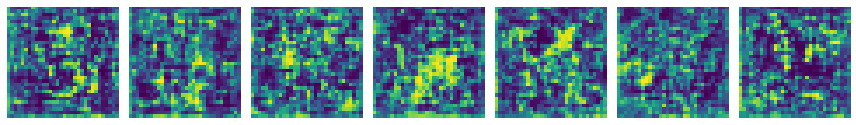

iteration:100 / d_loss:-3.893 / g_loss:-10.512


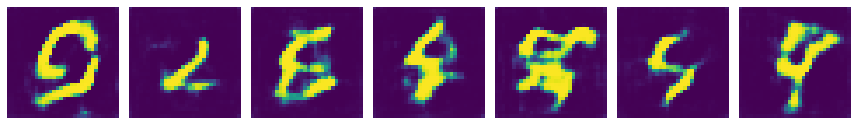

iteration:1000 / d_loss:-1.089 / g_loss:-5.021


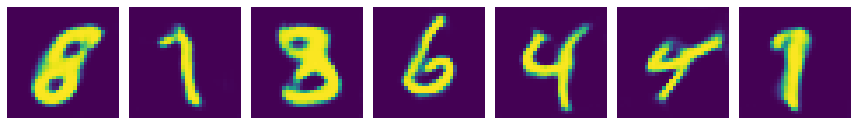

iteration:10000 / d_loss:-1.024 / g_loss:-1.893


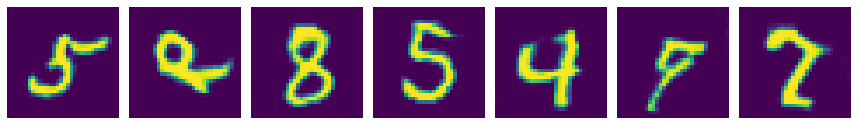

iteration:20000 / d_loss:-1.144 / g_loss:0.142


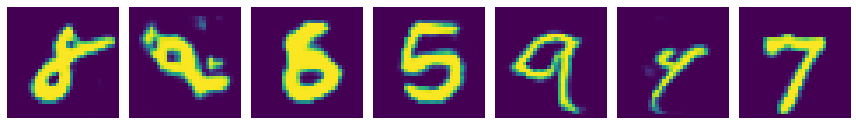

iteration:30000 / d_loss:-1.047 / g_loss:-0.438


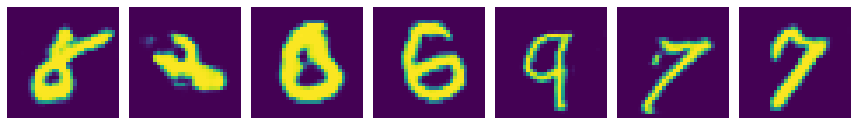

iteration:40000 / d_loss:-0.114 / g_loss:1.254


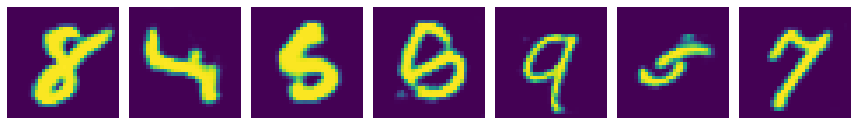

In [ ]:
iteration = 0
kernel_start = time.perf_counter()
kernel_time_limit = 60*60*8.5        #### running time

while time.perf_counter() - kernel_start < kernel_time_limit:
    
    #### Discriminator
    for j in range(trainRatio):
        # Generator in
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # Generator out Images
        f_imgs = generator.predict(z)
        # Real Images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        r_imgs = X_train[idx]
        # train the discriminator
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))
        r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

    #### Generator
    # Generator in
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # train the generator
    g_loss = G_train([z])

    # generated image sumple
    if (iteration in [100, 1000]) or (iteration % rec_interval == 0):
        elapsed = time.perf_counter() - kernel_start
        print(f'iteration:{iteration}, elapsed:{elapsed:.1f} : d_loss:{d_loss:.3f} , g_loss:{sum(g_loss)/len(g_loss):.3f}')
        g_imgs = generator.predict(z_fix)
        imgs = g_imgs * 127.5 + 127.5
        show_images(imgs, rows=1, cols=7)
        plt.show()

    iteration += 1
    
print("last iteration:",iteration - 1)